In [1]:
import random
import numpy as np
import time
import pandas as pd
from os.path import expanduser
import sqlite3
import alphatims.bruker
import alphatims.utils
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches

In [23]:
raw_file_dir = '/media/big-ssd/experiments/P3856/raw-databases/P3856_YHE211_1_Slot1-1_1_5104.d'
raw_file_name = '{}/analysis.tdf'.format(raw_file_dir)

In [24]:
# how much wider than the isolation window m/z range, to increase the likelihood of getting the monoisotope, in m/z
MS2_MZ_ISOLATION_WINDOW_EXTENSION = 0.7
# assumption about base peak width in RT
RT_BASE_PEAK_WIDTH_SECS = 10.0
# Mass difference between Carbon-12 and Carbon-13 isotopes, in Da. For calculating the spacing between isotopic peaks.
CARBON_MASS_DIFFERENCE = 1.003355
# the number of ms1 frames to look either side of the fragmentation event.
RT_FRAGMENT_EVENT_DELTA_FRAMES = 2
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [32]:
# returns a dataframe with the prepared isolation windows
def load_isolation_windows():
    # get all the isolation windows
    db_conn = sqlite3.connect(raw_file_name)
    isolation_window_df = pd.read_sql_query("select * from PasefFrameMsMsInfo order by Precursor", db_conn)
    db_conn.close()

    isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2) - MS2_MZ_ISOLATION_WINDOW_EXTENSION
    isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2) + MS2_MZ_ISOLATION_WINDOW_EXTENSION

    print("loaded {} isolation windows from {}".format(len(isolation_window_df), raw_file_name))
    return isolation_window_df

In [33]:
# returns a dataframe with the frame properties
def load_frame_properties():
    # get all the isolation windows
    db_conn = sqlite3.connect(raw_file_name)
    frames_properties_df = pd.read_sql_query("select * from Frames order by Id ASC;", db_conn)
    db_conn.close()

    print("loaded {} frame_properties from {}".format(len(frames_properties_df), raw_file_name))
    return frames_properties_df

In [34]:
def process_precursor(frame_properties_df, precursor_id, precursor_group_df):
    # calculate the coordinates
    window = precursor_group_df.iloc[0]
    window_mz_lower = window.mz_lower                                             # the isolation window's m/z range
    window_mz_upper = window.mz_upper
    wide_mz_lower = window_mz_lower - (CARBON_MASS_DIFFERENCE / 1)                # get more points in case we need to look for a missed monoisotopic peak - assume charge 1+ to allow for maximum distance to the left
    wide_mz_upper = window_mz_upper
    scan_width = int(window.ScanNumEnd - window.ScanNumBegin)                     # the isolation window's scan range
    fe_scan_lower = int(window.ScanNumBegin)                                      # fragmentation event scan range
    fe_scan_upper = int(window.ScanNumEnd)
    wide_scan_lower = int(window.ScanNumBegin - scan_width)                       # get more points to make sure we get the apex of the peak in drift
    wide_scan_upper = int(window.ScanNumEnd + scan_width)

    fe_ms2_frame_lower = precursor_group_df.Frame.astype(int).min()               # only the ms2 frames associated with the precursor
    fe_ms2_frame_upper = precursor_group_df.Frame.astype(int).max()

    fe_ms1_frame_lower,_ = find_closest_ms1_frame_to_ms2_frame(frame_properties_df,fe_ms2_frame_lower)
    _,fe_ms1_frame_upper = find_closest_ms1_frame_to_ms2_frame(frame_properties_df,fe_ms2_frame_upper)
    fe_ms1_rt_lower = metadata_for_frame(frame_properties_df, fe_ms1_frame_lower)['retention_time_secs']
    fe_ms1_rt_upper = metadata_for_frame(frame_properties_df, fe_ms1_frame_upper)['retention_time_secs']

    wide_ms1_rt_lower = fe_ms1_rt_lower - RT_BASE_PEAK_WIDTH_SECS  # get more points to make sure we get the apex of the peak in retention time
    wide_ms1_rt_upper = fe_ms1_rt_upper + RT_BASE_PEAK_WIDTH_SECS

    # collect the coordinates for the precursor cuboid
    precursor_coordinates_d = {
        'precursor_cuboid_id': int(precursor_id),
        'window_mz_lower': window_mz_lower,
        'window_mz_upper': window_mz_upper,
        'wide_mz_lower': wide_mz_lower,
        'wide_mz_upper': wide_mz_upper,
        'fe_scan_lower': int(fe_scan_lower),
        'fe_scan_upper': int(fe_scan_upper),
        'wide_scan_lower': int(wide_scan_lower),
        'wide_scan_upper': int(wide_scan_upper),
        'fe_ms1_rt_lower': fe_ms1_rt_lower,
        'fe_ms1_rt_upper': fe_ms1_rt_upper,
        'fe_ms2_frame_lower': fe_ms2_frame_lower,
        'fe_ms2_frame_upper': fe_ms2_frame_upper,
        'wide_ms1_rt_lower': wide_ms1_rt_lower,
        'wide_ms1_rt_upper': wide_ms1_rt_upper,
        'number_of_windows': len(precursor_group_df)
    }
    return precursor_coordinates_d

In [35]:
# find the closest lower ms1 frame_id, and the closest upper ms1 frame_id
def find_closest_ms1_frame_to_ms2_frame(frames_properties_df, ms2_frame_id):
    # get the ms2 frame's RT
    ms2_frame_rt = frames_properties_df[frames_properties_df.Id == ms2_frame_id].iloc[0].Time
    # get the closest ms1 frames
    return find_closest_ms1_frame_to_rt(frames_properties_df, ms2_frame_rt, RT_FRAGMENT_EVENT_DELTA_FRAMES)

In [36]:
# find the closest lower ms1 frame_id, and the closest upper ms1 frame_id
# number_of_ms1_frames_padding is the number of ms1 frames to extend
def find_closest_ms1_frame_to_rt(frames_properties_df, retention_time_secs, number_of_ms1_frames_padding=0):
    ms1_frame_props_df = frames_properties_df[(frames_properties_df.MsMsType == FRAME_TYPE_MS1)]
    # find the closest ms1 frame above
    df = ms1_frame_props_df[(ms1_frame_props_df.Time > retention_time_secs)]
    if len(df) > (number_of_ms1_frames_padding+1):
        closest_ms1_frame_above_rt = df.iloc[number_of_ms1_frames_padding].Id
    else:
        # couldn't find an ms1 frame above this RT, so just use the last one
        closest_ms1_frame_above_rt = ms1_frame_props_df.Id.max()
    # find the closest ms1 frame below
    df = ms1_frame_props_df[(ms1_frame_props_df.Time < retention_time_secs)]
    if len(df) > (number_of_ms1_frames_padding+1):
        closest_ms1_frame_below_rt = df.iloc[-(number_of_ms1_frames_padding+1)].Id
    else:
        # couldn't find an ms1 frame below this RT, so just use the first one
        closest_ms1_frame_below_rt = ms1_frame_props_df.Id.min()
    return (closest_ms1_frame_below_rt, closest_ms1_frame_above_rt)

In [37]:
def metadata_for_frame(frame_properties_df, frame_id):
    r = frame_properties_df[(frame_properties_df.Id == frame_id)].iloc[0]
    result = {}
    result['retention_time_secs'] = r.Time
    result['frame_type'] = r.MsMsType
    return result

In [38]:
isolation_windows_df = load_isolation_windows()

loaded 101914 isolation windows from /media/big-ssd/experiments/P3856/raw-databases/P3856_YHE211_1_Slot1-1_1_5104.d/analysis.tdf


In [39]:
frame_properties_df = load_frame_properties()

loaded 25701 frame_properties from /media/big-ssd/experiments/P3856/raw-databases/P3856_YHE211_1_Slot1-1_1_5104.d/analysis.tdf


In [40]:
cuboids_df = pd.DataFrame([process_precursor(frame_properties_df=frame_properties_df, precursor_id=group_name, precursor_group_df=group_df) for group_name,group_df in isolation_windows_df.groupby('Precursor')])

In [41]:
data = alphatims.bruker.TimsTOF(raw_file_dir)

100%|██████████| 25701/25701 [00:29<00:00, 878.56it/s] 


In [42]:
selected_cuboid = cuboids_df[(cuboids_df.precursor_cuboid_id==23911)].iloc[0]

In [43]:
selected_cuboid

precursor_cuboid_id    23911.000000
window_mz_lower          771.243561
window_mz_upper          775.376662
wide_mz_lower            770.240206
wide_mz_upper            775.376662
fe_scan_lower            582.000000
fe_scan_upper            607.000000
wide_scan_lower          557.000000
wide_scan_upper          632.000000
fe_ms1_rt_lower         1891.797393
fe_ms1_rt_upper         1894.443005
fe_ms2_frame_lower     16905.000000
fe_ms2_frame_upper     16905.000000
wide_ms1_rt_lower       1881.797393
wide_ms1_rt_upper       1904.443005
number_of_windows          1.000000
Name: 23910, dtype: float64

In [44]:
scan_buffer = 20.0
mz_buffer = 2.0

In [45]:
raw_df = data[
    {
        "rt_values": slice(selected_cuboid.fe_ms1_rt_lower, selected_cuboid.fe_ms1_rt_upper),
        "mz_values": slice(selected_cuboid.wide_mz_lower-mz_buffer, selected_cuboid.wide_mz_upper+mz_buffer),
        "scan_indices": slice(int(selected_cuboid.wide_scan_lower-scan_buffer), int(selected_cuboid.wide_scan_upper+scan_buffer)),
        "precursor_indices": 0,
    }
]

In [46]:
raw_df.sort_values(by=['intensity_values'], ascending=True, inplace=True)

In [47]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.Normalize(vmin=10, vmax=raw_df.intensity_values.max(), clip=True)

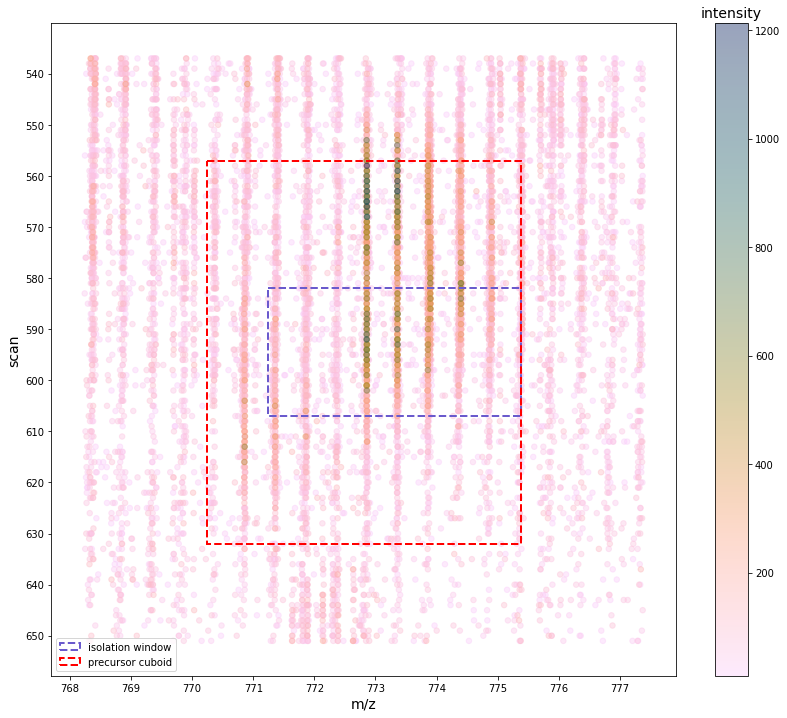

In [63]:
f, ax1 = plt.subplots()
f.set_figheight(12)
f.set_figwidth(14)

plt.margins(0.06)

plt.scatter(raw_df.mz_values, raw_df.scan_indices, c=raw_df.intensity_values, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)

# draw the isolation window
top_left = (selected_cuboid.window_mz_lower,selected_cuboid.fe_scan_lower)
width = selected_cuboid.window_mz_upper - selected_cuboid.window_mz_lower
height = selected_cuboid.fe_scan_upper - selected_cuboid.fe_scan_lower
isolation_rect = patches.Rectangle(top_left,width,height,linewidth=2.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='isolation window')
ax1.add_patch(isolation_rect)

# draw the cuboid
top_left = (selected_cuboid.wide_mz_lower,selected_cuboid.wide_scan_lower)
width = selected_cuboid.wide_mz_upper - selected_cuboid.wide_mz_lower
height = selected_cuboid.wide_scan_upper - selected_cuboid.wide_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=2.0,linestyle='--',edgecolor='red',facecolor='none',label='precursor cuboid')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z", fontsize=14)
plt.ylabel("scan", fontsize=14)

nearest = 1.0
range_l = round(raw_df.mz_values.min() / nearest) * nearest
range_u = round(raw_df.mz_values.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(raw_df.scan_indices.min() / nearest) * nearest
range_u = round(raw_df.scan_indices.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

# plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()

# Plot colorbar
cbar = plt.colorbar()
cbar.ax.set_title('intensity', fontsize=14)

plt.show()